## Baseline one object dataset
Testing dataset with one object of random shape and color in very easy rendering (basically for making sure that the model architecture works)

In [36]:
import numpy as np

import sampling
from evaluation import evaluate_sample
from environment import grab_frame, reset_env

frame_size = (64, 64)
dataset_path = 'data/baseline_dataset'

def sample_func():    
    obj = sampling.ObjectOnTable.sample(origin=(0, 0, 1.0), max_bounds=(0, 0, 0), max_rotation=2 * np.pi)
    
    predicates = sampling.get_on_table_relation(obj, None, add_positional=False)
    predicates.extend(sampling.get_false_predicates(predicates, 1))

    reset_env()
    sampling.create_shape(obj)
    frame = grab_frame(cam_pos=(0, -5, 1), cam_target=(0, 0, 1), light_dir=(-6, 1, 10), frame_size=frame_size)
    return frame, predicates

In [37]:
# Run only once!
from batching import create_dataset
create_dataset(dataset_path, 32, 128, sample_func)

Generating 32 * 128 = 4096 samples


100%|██████████| 32/32 [01:45<00:00,  3.28s/it]


In [44]:
# Run only once!
create_dataset(dataset_path + "_testing", 8, 128, sample_func)

Generating 8 * 128 = 1024 samples


100%|██████████| 8/8 [00:26<00:00,  3.25s/it]


In [45]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

frame_inputs = layers.Input(shape=(*frame_size, 3))
x = layers.Rescaling(1.0 / 255.0)(frame_inputs)

for size in (8, 8, 8):
    x = layers.Conv2D(size, 3, padding="same", activation='relu')(x)
    x = layers.MaxPooling2D(2, padding="same")(x)        

x = layers.Flatten()(x)
conv_branch_outputs = layers.Dense(64, activation='relu')(x)

predicate_inputs = layers.Input(shape=(33,))
predicate_branch_outputs = layers.Dense(64, activation='relu')(predicate_inputs)

x = layers.concatenate([conv_branch_outputs, predicate_branch_outputs], axis=-1)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model([frame_inputs, predicate_inputs], outputs)
model.summary()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
rescaling_8 (Rescaling)         (None, 64, 64, 3)    0           input_17[0][0]                   
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 64, 64, 8)    224         rescaling_8[0][0]                
__________________________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D) (None, 32, 32, 8)    0           conv2d_24[0][0]                  
____________________________________________________________________________________________

In [46]:
from batching import load_as_tf_dataset
training_set = load_as_tf_dataset(dataset_path).shuffle(128).batch(32)
testing_set = load_as_tf_dataset(dataset_path + "_testing").batch(32)

In [47]:
%%time
progress = model.fit(training_set, validation_data=testing_set, epochs=5)

Epoch 1/5
256/256 [==============================] - 4s 13ms/step - loss: 0.4230 - accuracy: 0.8324 - val_loss: 0.1549 - val_accuracy: 0.9536
Epoch 2/5
256/256 [==============================] - 3s 13ms/step - loss: 0.0620 - accuracy: 0.9872 - val_loss: 0.0212 - val_accuracy: 0.9990
Epoch 3/5
256/256 [==============================] - 3s 13ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 4/5
256/256 [==============================] - 3s 13ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 5/5
256/256 [==============================] - 3s 13ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
CPU times: user 17 s, sys: 1.3 s, total: 18.3 s
Wall time: 17.2 s


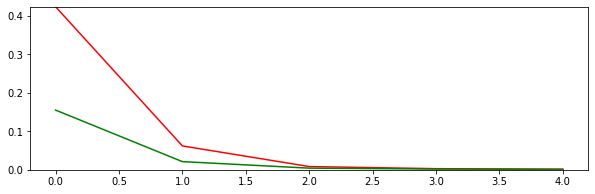

In [51]:
from utils import draw_progress
draw_progress(progress, fit_line=False)

In [56]:
from evaluation import evaluate_sample
probes = sampling.get_on_table_probes(add_positional=False)

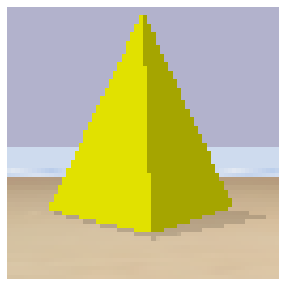

(yellow pyramid on table) 1.0
(green pyramid on table) 0.0
---
(yellow pyramid on table) 0.99921477


In [57]:
evaluate_sample(sample_func, model, probes)